## word-embedding

在构建 count-based 语言模型的时候，我们把所有看到的词都放入了 dict 里面，这时候影响不大，因为每个词占用的内存较小。

在使用神经网络做自然语言处理的时候，我们一般都会对词表做一个截断操作，取最高频的 n 个（也有人按词频阈值做截断）。这样有两个好处：
1. 减少模型的内存使用。
2. 只出现过一两次的词，在整个优化过程中往往也很难学好。不如把这些词直接全看成未登录词。

### 运行环境

docker image `tensorflow/tensorflow`, Python 3.4.3

In [1]:
%matplotlib inline
from collections import Counter
import time
import jieba
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

1.0.1


### 读取语料，生成训练数据

简便起见，忽略首尾词，否则需要设置文首文末的 token。  
context words 取一左一右。

In [2]:
read_size = 100000
vocab_size = 2000 + 1  # 预留一个未登录词

with open('../ch1/ZhangAiLing.txt', encoding='utf-8') as f:
    corpus = f.read(read_size)

words = [word for word in jieba.cut(corpus) if word not in ' \n']
word_cnt = Counter(words)
vocab = [i[0] for i in word_cnt.most_common(vocab_size - 1)]  # 词表(高频截断)
vocab.insert(0, 'UNK')

# 将语料序列映射到 [0, vocab_size - 1] 内的整数, 未登录词为 0
word_ids = [vocab.index(word) if (word in vocab) else 0 
            for word in words]

# 生成训练数据
inputs_train = np.asarray([[word_ids[i-1], word_ids[i+1]] 
                           for i in range(1, len(word_ids) - 1)])
labels_train = np.asarray(word_ids[1:-1])

# 查看截断位置的词频
word_cnt.most_common(vocab_size)[-5:]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.757 seconds.
Prefix dict has been built succesfully.


[('天色', 3), ('恐怖', 3), ('活该', 3), ('手续', 3), ('光阴', 3)]

In [3]:
len(corpus), len(words), len(vocab), inputs_train.shape, labels_train.shape

(100000, 67488, 2001, (67486, 2), (67486,))

### 定义神经网络

#### 定义 Variable 和 placeholder

Word embeddings 定义为 Variable，需要做随机初始化。它相当于普通神经网络中的权重。

inputs 是 int32 类型，每行为一条样本中输入词的 ID。这里我们需要对数据进行预处理，把高频词映射到 [1, vocab_size - 1] 之间，不在词表里面的词设置成 UNK, ID 为 0。

inputs 的 Shape，第一维我们指定为 None，可以根据数据而变化，因此同样一个程序可以适应梯度下降时不同的 batch_size。

In [4]:
tf.reset_default_graph()
word_embedding_dim = 50
word_embeddings = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))
inputs = tf.placeholder(tf.int32, shape=[None, 2], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

#### lookup 得到 input 词的 embedding

对矩阵 inputs 作 lookup 之后，得到的是一个 rank-3 的张量。其第1个维度大小未知，取决于样本数量。

In [5]:
input_embeds = tf.nn.embedding_lookup(word_embeddings, inputs)
input_embeds

<tf.Tensor 'embedding_lookup:0' shape=(?, 2, 50) dtype=float32>

#### 词向量相加，并映射到输出层（N 个词的概率分布）

接下来对两个 context 词的 word embedding 求和。

reduce 开头的函数一般有一个 axis 参数，决定按行、按列或者按整个矩阵进行 reduce

相加得到的 context_embds 的第一维仍然是未知的。

In [6]:
context_embeds = tf.reduce_sum(input_embeds, axis=1)
context_embeds

<tf.Tensor 'Sum:0' shape=(?, 50) dtype=float32>

In [7]:
raw_output = tf.layers.dense(context_embeds, vocab_size)
output = tf.nn.softmax(raw_output)
raw_output.shape, labels_train.shape

(TensorShape([Dimension(None), Dimension(2001)]), (67486,))

#### cost function

与 sigmoid 类似, softmax 配合 cross entropy 的时候，在求导时两个连着看，也可以做分母的消除，因此在计算 cost 的时候我们要把 raw_output 喂给 tf 的这个损失函数.

因为我们每个样本的 label 只有一个，使用稠密的 softmax 算 cost 及求导太浪费了。这里使用 sparse 版本即可。如果你的 label 是完整的 N 个词上的概率分布，这时候可以使用 tf.nn.softmax_cross_entropy_with_logits

In [8]:
cost = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits=raw_output, labels=labels))

### 训练

最初用全量梯度下降, 后改用随机梯度下降(v2), 速度明显加快.  
再由随机梯度下降改为小批量梯度下降(v4)

不过不大理解的是, 为什么 cost 在训练后期反而上升?

In [9]:
labels.shape, labels_train.shape, inputs.shape, inputs_train.shape

(TensorShape([Dimension(None)]),
 (67486,),
 TensorShape([Dimension(None), Dimension(2)]),
 (67486, 2))

In [34]:
learning_rate = 3
epochs = 1000
print_cost_every = 10
batch_size = 100
feed = {inputs: inputs_train, labels: labels_train}  # full-batch feed

In [35]:
# writer = tf.summary.FileWriter('/tensorflow/tf')
# cost_summary = tf.summary.scalar('cost_', cost)
# embedding_summary = tf.summary.histogram('embeddings_', word_embeddings)
# merged = tf.summary.merge_all()

train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
costs = []

# 训练集的随机序号
num_inputs = len(labels_train)
order = np.arange(num_inputs)
np.random.shuffle(order)

start_time = time.time()

try:
    for i in range(epochs):
        if i % print_cost_every == 0:
            cost_value, merged_value = sess.run([cost, merged], feed_dict=feed)
            print("Epoch {:03d} - Cost: {:.5f}".format(i, cost_value))
            costs.append(cost_value)
            writer.add_summary(merged_value, i)
        for j in range(0, num_inputs, batch_size):
            batch_index = order[j: j + batch_size]
            batch_inputs = inputs_train[batch_index]
            batch_labels = labels_train[batch_index]
            batch_feed = {inputs: batch_inputs, labels: batch_labels}
            sess.run(train_step, feed_dict=batch_feed)
except KeyboardInterrupt:
    print('KeyboardInterrupt')
finally:
    end_time = time.time()
    print('\ntime: {:.2f} s'.format(end_time - start_time))

Round 000 - Cost: 7.63822
Round 010 - Cost: 3.32822
Round 020 - Cost: 3.07603
Round 030 - Cost: 3.02027
Round 040 - Cost: 3.02089
Round 050 - Cost: 3.03762
Round 060 - Cost: 3.05802
Round 070 - Cost: 3.07785
Round 080 - Cost: 3.09582
KeyboardInterrupt

time: 452.78 s


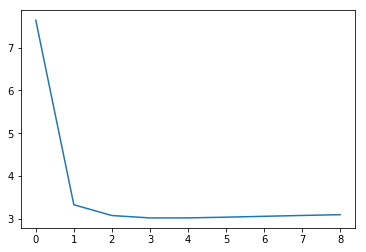

In [36]:
plt.plot(costs);

### 比较词向量相似性

完成 3 个名词各自最相近的 Top 10 个词的检索

原先用 for 循环的方式, 后按童老师建议修改为矩阵乘法方式, 参考 [tensorflow_cookbook/05_Working_With_CBOW.ipynb](https://github.com/nfmcclure/tensorflow_cookbook/blob/master/07_Natural_Language_Processing/05_Working_With_CBOW_Embeddings/05_Working_With_CBOW.ipynb)

In [37]:
validate_words = ['叔惠', '家里', '茶杯', '手套']
validate_ids = [vocab.index(word) for word in validate_words]
validate_inputs = tf.constant(validate_ids, dtype=tf.int32)

norm = tf.sqrt(tf.reduce_sum(tf.square(word_embeddings), 1, keep_dims=True))
normalized_embeddings = word_embeddings / norm
validate_embeddings = tf.nn.embedding_lookup(normalized_embeddings, validate_inputs)
similarity = tf.matmul(validate_embeddings, normalized_embeddings, transpose_b=True)

In [38]:
sim_values = sess.run(similarity, feed_dict=feed)
for i in range(len(validate_words)):
    word = validate_words[i]
    similar_ids = (-sim_values[i, :]).argsort()[1: 11]
    similar_words = [vocab[j] for j in similar_ids]
    print('similar to {}:'.format(word))
    print(similar_words)

similar to 叔惠:
['世钧', '慕瑾', '他', '曼桢', '顾太太', '她', '我', '一鹏', '嘴里', '翠芝']
similar to 家里:
['一幢', '身上', '妹妹', '对于', '这儿', '一块儿', '将来', '和世钧', '乡下', '房里']
similar to 茶杯:
['鞋子', '公馆', '听筒', '鞋', '无线电', '使劲', '抽屉', '裤袋', '这间', '里头']
similar to 手套:
['白', '钟', '茶叶', '报纸', '头发', '镜子', '背', '枕头', '包车', '桂花']


### ch6 task1: 比较不同 batch_size 的预测运算时间

In [39]:
def batch_predict_time(size):
    batch_index = np.random.choice(num_inputs, size, replace=False)
    batch_inputs = inputs_train[batch_index]        
    predictions = tf.argmax(output, 1)
    start = time.time()
    predictions_val = sess.run(predictions, feed_dict={inputs: batch_inputs})
    end = time.time()
    return end - start

In [40]:
%timeit batch_predict_time(1)

10 loops, best of 3: 38.9 ms per loop


In [41]:
%timeit batch_predict_time(100)

10 loops, best of 3: 41.5 ms per loop


In [42]:
%timeit batch_predict_time(1000)

10 loops, best of 3: 64.2 ms per loop


In [45]:
batch_predict_time(1), batch_predict_time(100), batch_predict_time(1000)

(0.05188274383544922, 0.05747032165527344, 0.06839132308959961)

结果: 
* 预测的 batch_size 从 1 增大到 100, 耗费的时间竟然没怎么增加!
* 从 1 到 1000, 耗费的时间也没有超过两倍.

### ChangeLog


`v4a`
* 学习率由 0.1 改为 3, 训练时间从 1h+ 减少至 不到10分钟...
* 教训: 训练前, **确保学习率在能收敛的前提下取较大的值!** 特别是在模型变更之后, 学习率要重新选取

`v4`
* 改用 mini-batch 梯度下降. (batch size 100, 学习率 0.1)
* 奇怪, 训练速度并没有加快. 用时 5000+ s.
  * 学习率取得太小了!!

`v3`
* 样本加大到 10w 词(有效词 6w+), 词向量维度 30->50, vocab_size 400->2000
* 结果的相似性明显提高
* 按 ch5 task2 增加 summary 输出

`v2`
* 采用 SGD, 速度明显加快
* 用向量化方法计算相似度, 取代低效的 for 循环

`v0~v1`  
* 结果大体上有一点 sense。人名对人名，物件对物件。  
* 考虑到这些前提，结果大致可以接受：
    * 样本不到 10000 词，算非常小了
    * context 只取了一左一右两个词，并不能很准确地捕捉上下文
    * 并未做什么优化